<a href="https://colab.research.google.com/github/shariqfz/Fake-News-Detection-Text-Classification/blob/main/RandomForestClassifier/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
%%capture
import re
import pandas as pd

In [13]:
# Importing necessary paackages

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.ensemble import RandomForestClassifier


seed = 5343

# Fetching Data

In [3]:
%%capture
#Get Original dataset
!mkdir -p data
!git clone 'https://github.com/shariqfz/Fake-News-Detection-Text-Classification.git'
!tar -zxvf '/content/Fake-News-Detection-Text-Classification/data/FakeNewsData.tar.gz'
!mv ./FakeNewsData/Fake.csv ./FakeNewsData/True.csv ./data
!rm -r /content/FakeNewsData /content/sample_data

In [38]:
# true = pd.read_csv('/content/data/True.csv')
# fake = pd.read_csv('/content/data/Fake.csv')

In [4]:
fake_news_path = "/content/data/True.csv"
real_news_path = "/content/data/Fake.csv"

In [5]:
fake_news = pd.read_csv(fake_news_path)
real_news = pd.read_csv(real_news_path)

In [6]:
fake_news.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [7]:
real_news.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [8]:
real = real_news.copy()
fake = fake_news.copy()

In [9]:
real['impression'] = 'Real'
fake['impression'] = 'Fake'

In [ ]:
news = pd.concat([real, fake], axis=0, ignore_index=True)
news.reset_index()
news.tail(5)

In [11]:
print(f"Samples available: {news.shape[0]}\n#features of dataset: {news.shape[1]}")

Samples available: 44898
#features of dataset: 5


In [ ]:
class_dist = px.histogram(data_frame=news,
                         y='impression',
                         color='impression',
                         title='Fake vs Real news Original dataset',
                         text_auto=True)
class_dist.update_layout(showlegend=False)
class_dist.show()

In [ ]:
subject_dist = px.histogram(data_frame=news,
                           x='subject',
                           color='subject',
                           title='Fake vs Real news Subject Distribution',
                           text_auto=True,
                           facet_col='impression')
subject_dist.update_layout(showlegend=False)
subject_dist.show()

In [18]:
news.date.unique().max()

'https://fedup.wpengine.com/wp-content/uploads/2015/04/hillarystreetart.jpg'

In [ ]:
list(filter(lambda x:len(x)>20, news.date.unique()))

In [ ]:
news = news[news['date'].map(lambda x:len(x)) <= 20]
news.date = pd.to_datetime(news['date'], format='mixed',infer_datetime_format=True)
news.head()

In [ ]:
date_dist = px.histogram(data_frame=news,
                         x='date',
                         color='impression')
date_dist.show()

In [ ]:
subject_dist = px.histogram(data_frame=news,
                           x='date',
                           color='subject')
subject_dist.show()

In [ ]:
real_sub_dist = px.histogram(data_frame=news[news['impression']=='Real'],
                            x='date',
                            color='subject')
real_sub_dist.show()

In [48]:
CLASS_NAMES = ['Fake', 'Real']
class_mapper = {
    'Fake':0,
    'Real':1
}

In [ ]:
news['impression'] = news['impression'].map(class_mapper)


In [50]:
news.tail(5)

,title,text,subject,date,impression
44893,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",0
44894,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",0
44895,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",0
44896,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",0
44897,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",0


# Combining title and text to obtain a single string

In [51]:
# Combining title and text to obtain a single string

news['fulltext'] = news.title + ' ' + news.text
news.drop(['title','text'], axis=1, inplace=True)

In [52]:
# Extracting a new dataframe using features fulltext and impression
data = news[['fulltext', 'impression']]
data = data.reset_index()
data.drop(['index'], axis=1, inplace=True)

In [53]:
# Check for missing values

data.isnull().sum()

fulltext      0
impression    0
dtype: int64

In [54]:
print('The dataset contans {} rows and {} columns'.format(data.shape[0], data.shape[1]))

The dataset contans 44898 rows and 2 columns


In [55]:
# Word extraction from true and fake texts

true_text = data[data.impression==1]['fulltext']
fake_text = data[data.impression==0]['fulltext']
fake_text = fake_text.reset_index().drop(['index'], axis=1)
true_text = true_text.reset_index().drop(['index'], axis=1)

In [56]:
import nltk
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

# Generating Wordcloud for Analysis

In [57]:
# Function to extract major words from true and fake news

def wordcloud_words(X_data_full):

    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2

    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full.iloc[i])
        X_data_full_clear_punct.append(test_data)

    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2

    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full.iloc[i])
        X_data_full_clear_stopwords.append(test_data)

    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words

    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full.iloc[i])
        X_data_full_tokenized_words.append(test_data)

    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words

    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full.iloc[i])
        X_data_full_lemmatized_words.append(test_data)

    return X_data_full_lemmatized_words

In [59]:
true_sample = true_text.sample(n=10000, random_state=1)
true_words = wordcloud_words(true_sample.fulltext)
fake_sample = fake_text.sample(n=10000, random_state=1)
fake_words = wordcloud_words(fake_sample.fulltext)

In [60]:
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color = 'black',
                         max_words = 3000,
                         width=1600,
                         height=800).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

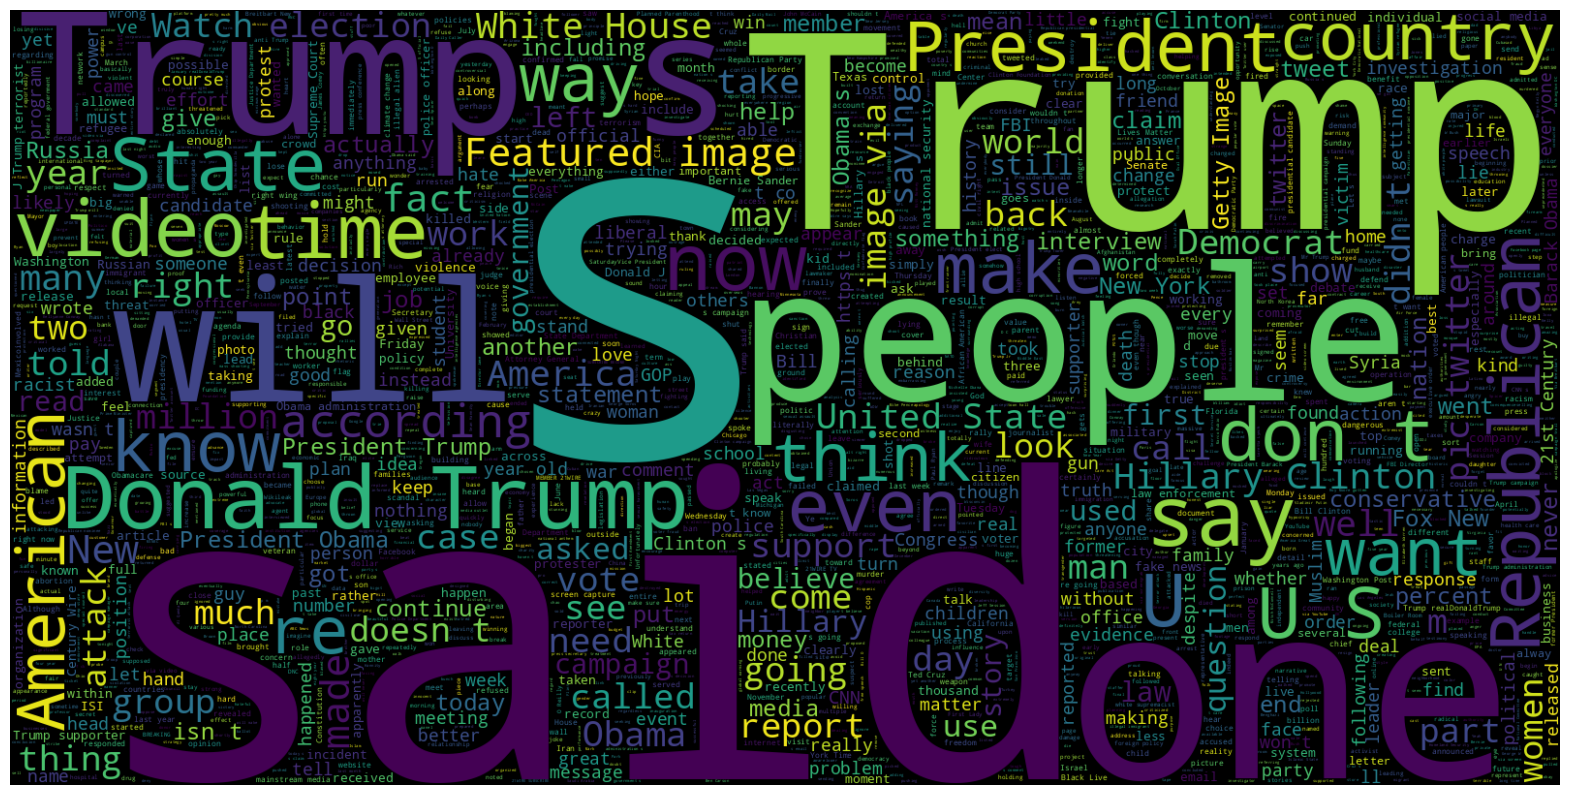

In [61]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(true_words))

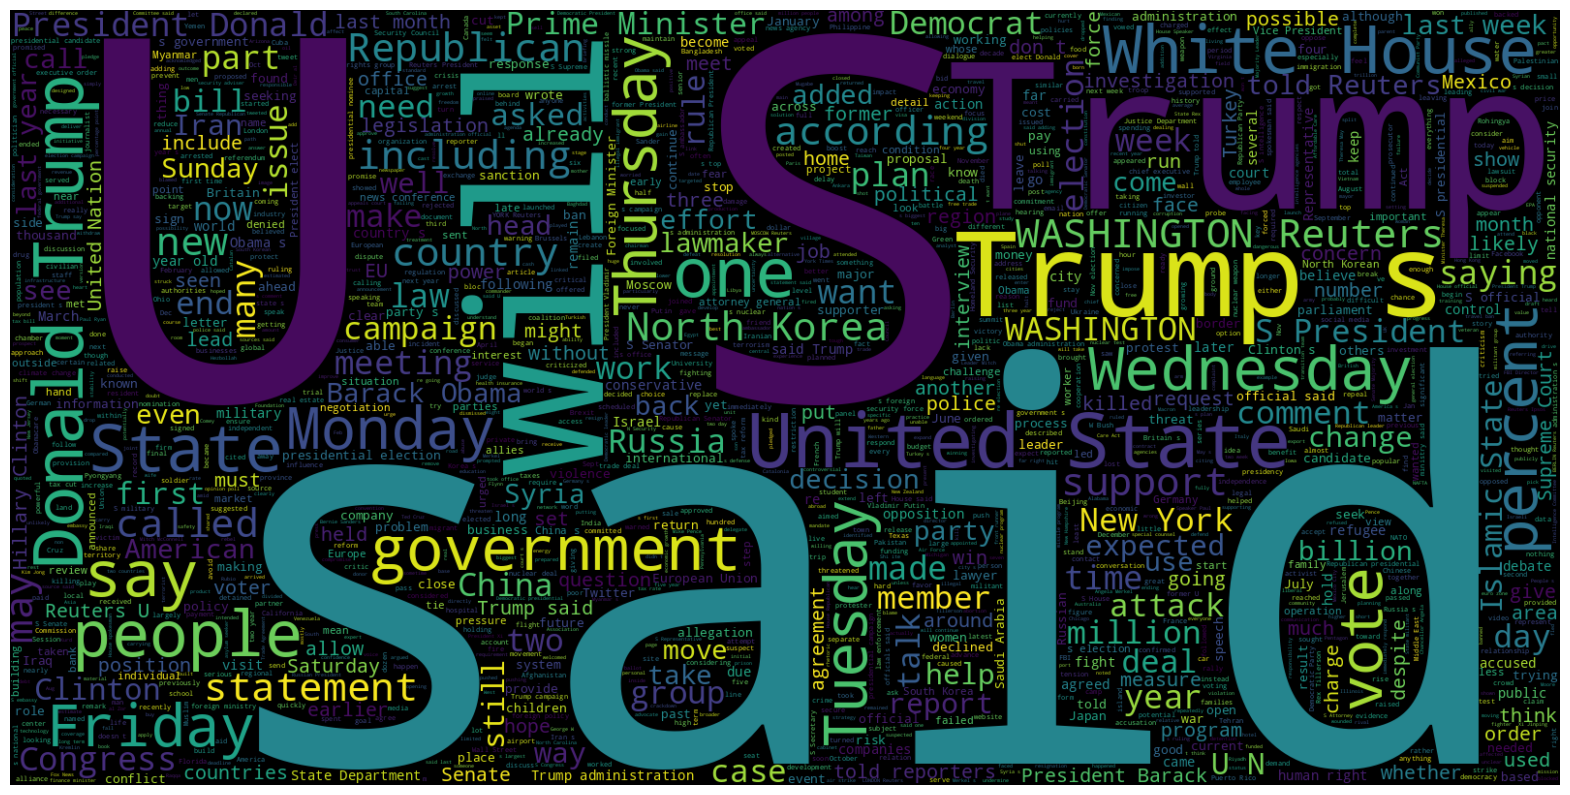

In [62]:
plt.figure(figsize=(20,18))
plot_wordcloud(' '.join(fake_words))

In [63]:
# Sample 10k rows from the dataset
data_sample = data.sample(n=10000, random_state=1)
X_data = data_sample['fulltext'].astype(str)
y_data = data_sample['impression']

In [64]:
X_data.head(10)

4528      Trump Calls For This Racist Policy To Be Forc...
31727    Republican ex-defense secretary Cohen backs Hi...
10937    TEACHER QUITS JOB After 5th, 6th Grade Muslim ...
13470    LAURA INGRAHAM RIPS INTO THE PRESS…Crowd Goes ...
40814    Germany's Merkel suffers state vote setback as...
12702    WHOA! MELANIA TRUMP BREAKS HER SILENCE…Fires B...
2736      Study Shows Democrats Are Better Drivers For ...
31730    U.S. lawmakers want moratorium on commercial f...
42479    The new risk for Europe: an inward-looking Ger...
26780    Trump still standing, but damaged by Comey's t...
Name: fulltext, dtype: object

# PreProcessing

In [65]:
# Function to retrieve processed words

def final(X_data_full):

    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, string.punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2

    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full.iloc[i])
        X_data_full_clear_punct.append(test_data)

    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2

    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full.iloc[i])
        X_data_full_clear_stopwords.append(test_data)

    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words

    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full.iloc[i])
        X_data_full_tokenized_words.append(test_data)

    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words

    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full.iloc[i])
        X_data_full_lemmatized_words.append(test_data)

    # creating the bag of words model
    cv = CountVectorizer(max_features=1000)
    X_data_full_vector = cv.fit_transform(X_data_full_lemmatized_words).toarray()


    tfidf = TfidfTransformer()
    X_data_full_tfidf = tfidf.fit_transform(X_data_full_vector).toarray()

    return X_data_full_tfidf

# Model Building and making prediction

In [66]:
# Setting the function with parameters

data_X = final(X_data)

In [67]:
# Preparing training and testing data using train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X, y_data, test_size=0.20, random_state= seed)

In [68]:
# Fitting the model and making prediction

rfc=RandomForestClassifier(n_estimators= 10, random_state= seed)
rfc.fit(X_train, y_train)
predictions = rfc.predict(X_test)

# Evaluating the model

In [69]:
# Finding Classification report

print(classification_report(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average= 'weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy : " , rfc_accuracy , " %")
print("f1_score : " , rfc_f1)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       954
           1       1.00      0.99      0.99      1046

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

Accuracy :  99.25  %
f1_score :  0.993


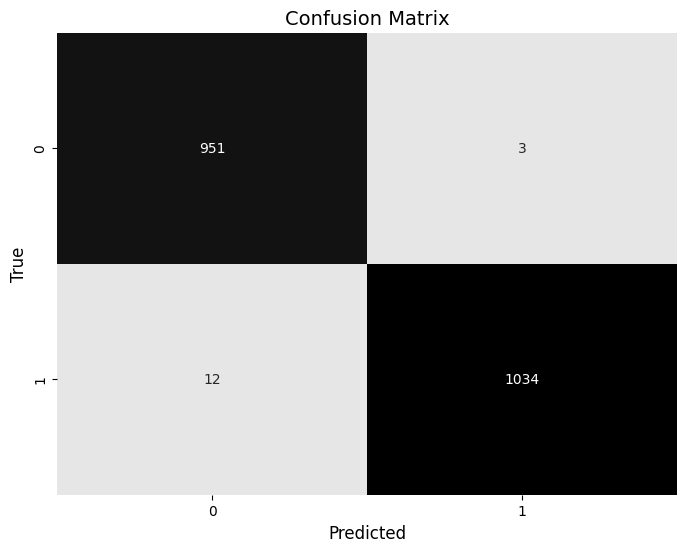

In [70]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Define a custom color palette
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0)

# Create a heatmap with custom styling
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=rfc.classes_, yticklabels=rfc.classes_)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Confusion Matrix', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


# Now we can apply Cross Validation

In [71]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    # Add other hyperparameters to tune
}


In [72]:
rfc = RandomForestClassifier(random_state=seed)
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='accuracy')


In [73]:
grid_search.fit(X_train, y_train)


KeyboardInterrupt: ignored

In [ ]:
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Hyperparameters: ", best_params)
print("Best Accuracy: ", best_accuracy)


In [ ]:
best_rfc = grid_search.best_estimator_
predictions = best_rfc.predict(X_test)

# Evaluate the best model
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

rfc_f1 = round(f1_score(y_test, predictions, average='weighted'), 3)
rfc_accuracy = round((accuracy_score(y_test, predictions) * 100), 2)

print("Accuracy: ", rfc_accuracy, " %")
print("F1 Score: ", rfc_f1)


In [ ]:
from sklearn.model_selection import learning_curve

# Define the RandomForestClassifier with the best hyperparameters (from GridSearchCV)
best_rfc = grid_search.best_estimator_

# Create learning curves
train_sizes, train_scores, validation_scores = learning_curve(
    best_rfc, data_X, y_data, train_sizes=[0.1, 0.2, 0.4, 0.6, 0.8], cv=5, scoring='accuracy'
)

# Calculate the mean and standard deviation of training and validation scores
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = validation_scores.mean(axis=1)
validation_scores_std = validation_scores.std(axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.title("Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Accuracy")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Validation Accuracy")

plt.legend(loc="best")
plt.show()
